In [1]:
!pip install torchtune
!pip install torchao
import torch.nn as nn
import torch
import numpy as np
import random
import math
import os
import torchtune.modules as ttm
import time
import tqdm
from sklearn.metrics import fbeta_score
import json
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.9/686.9 kB 14.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 58.7 MB/s eta 0:00:00:00:01
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=805f0945dd68cd1ab87dc16f2aeb993ab4ff65689cd9e309fc3dc6b2a2458ec6
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.6 MB/s eta 0:00:00a 0:00:01


In [2]:
def seed(seed=1):
    global rank   
    global random_seed 
    random_seed = seed
    #lib seeds
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    rank = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def create_loaders(rank, batch_size=16):
    # Load the tensors from files
    train_images = torch.load(r'/kaggle/input/imagenet-10/image_net_10/train_images.pt', weights_only=True)
    train_labels = torch.load(r'/kaggle/input/imagenet-10/image_net_10/train_labels.pt', weights_only=True)

    val_images = torch.load(r'/kaggle/input/imagenet-10/image_net_10/val_images.pt', weights_only=True)
    val_labels = torch.load(r'/kaggle/input/imagenet-10/image_net_10/val_labels.pt', weights_only=True)

    test_images = torch.load(r'/kaggle/input/imagenet-10/image_net_10/test_images.pt', weights_only=True)
    test_labels = torch.load(r'/kaggle/input/imagenet-10/image_net_10/test_labels.pt', weights_only=True)

    train_dataset = torch.utils.data.TensorDataset(train_images.float(), train_labels.long())
    val_dataset = torch.utils.data.TensorDataset(val_images.float(), val_labels.long())
    test_dataset = torch.utils.data.TensorDataset(test_images.float(), test_labels.long())



    def collate_gpu(batch):
        return (ele.to(rank) for ele in torch.utils.data.default_collate(batch))
    
    num_workers = 0
    persistent_workers = False
    #dataloaders 
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, persistent_workers=persistent_workers, shuffle=True, collate_fn=collate_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, persistent_workers=persistent_workers, collate_fn=collate_gpu)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, persistent_workers=persistent_workers, collate_fn=collate_gpu)

    return train_loader, val_loader, test_loader

In [4]:
from copy import deepcopy
class EarlyStoppingLoss():
    def __init__(self, patience):
        self._patience = patience
        self.current_patience = 0
        self.min_loss = float('inf')
        self.val_accuracy = None
        self.min_state_dict = None
        self.train_loss = None
        self.train_accuracy = None
        self.epoch = 0
        self.kept_epoch = None

    def stopper(self, current_model, train_loss, val_loss, train_accuracy=None, val_accuracy=None, val_f1=None):
        self.epoch += 1
        if val_loss < self.min_loss:
            self.train_loss = train_loss
            self.min_loss = val_loss
            
            self.train_accuracy = train_accuracy
            self.val_accuracy = val_accuracy

            self.val_f1 = val_f1 

            self.current_patience = 0
            self.min_state_dict = deepcopy({key: value.cpu() for key, value in current_model.state_dict().items()})
            self.kept_epoch = self.epoch
            
        else:
            self.current_patience += 1
        
        if self.current_patience >= self._patience:
            return True
        else:
            return False
        
    def get_state_dict(self):
        return self.min_state_dict  
    
    def get_current_patience(self):
        return self.current_patience
    
    def get_min_loss(self):
        return self.min_loss
    
    def get_kept_epoch(self):
        return self.kept_epoch
    
    def get_final_stats(self):
        return self.kept_epoch, self.train_loss, self.min_loss, self.train_accuracy, self.val_accuracy, self.val_f1

In [5]:
def train(model, train_loader, val_loader, loss_func, optimizer, early_stopper, lr_scheduler, num_epochs, use_progress_bar=True, epoch_checkpoints_path=None):
    #list to track metrics
    train_loss_lst = []
    val_loss_lst = []
    train_accuracy_lst = []
    val_accuracy_lst = []
    val_f1_lst = []
   
    #logging lst 
    logging_str = ''
        
    #timing training 
    start_total_time = time.time()
    
    #training loop
    epoch = 0
    for _ in range(num_epochs):
        ##TRAINING##
        model.train()

        #init running vars 
        train_running_loss = 0 
        #init accuracy vars
        train_correct_preds = 0

        #epoch start time 
        start_epoch_time = time.time()

        for step, (images, labels) in tqdm.tqdm(enumerate(train_loader), total=len(train_loader), mininterval=30, disable=not use_progress_bar):
            #clear grad
            optimizer.zero_grad()

            # Get model predictions
            train_preds = model(images)
  
            # Calculate loss
            train_batch_loss = loss_func(train_preds, labels)
            
            #incrmenting running loss 
            train_running_loss += train_batch_loss.item()
            
            #grad and backprop
            train_batch_loss.backward()
            optimizer.step()
            
            if isinstance(loss_func, nn.CrossEntropyLoss):
                #calculating accuracy 
                train_correct_preds += (torch.argmax(train_preds, dim=-1) == labels).sum().item()
            else:
                #calculating accuracy 
                train_correct_preds += (torch.round(torch.sigmoid(train_preds)) == labels).sum().item()

        #dividing the loss and correct preds by total samples to yield average 
        train_loss = train_running_loss / len(train_loader)
        #calaculting the accuracy for this epoch 
        train_accuracy = train_correct_preds / len(train_loader.dataset)

        ##VALIDATION##
        model.eval()
        #init running vars
        val_running_loss = 0
        #init accuracy vars
        val_correct_preds = 0

        #f1 vars 
        cat_preds = np.array([], dtype=np.int8)
        cat_labels = np.array([], dtype=np.int8)

        with torch.no_grad():
            for images, labels in val_loader:
                
                #getting batch preds
                val_preds = model(images)

                #getting loss 
                val_batch_loss = loss_func(val_preds, labels)
                    
                #incrmenting running loss 
                val_running_loss += val_batch_loss.item()

                if isinstance(loss_func, nn.CrossEntropyLoss):
                    val_cls_preds = torch.argmax(val_preds, dim=-1)
                    #calculating accuracy 
                    val_correct_preds += (val_cls_preds == labels).sum().item()
                    #filling f1 arrays 
                    cat_preds = np.concatenate((cat_preds, val_cls_preds.cpu().numpy().astype(np.int8)))
                    cat_labels = np.concatenate((cat_labels, labels.view(-1).cpu().numpy().astype(np.int8)))
                
                else:
                    val_cls_preds = torch.round(torch.sigmoid(val_preds))
                    #calculating accuracy 
                    val_correct_preds += (val_cls_preds == labels).sum().item()
                    #filling f1 arrays 
                    cat_preds = np.concatenate((cat_preds, val_cls_preds.cpu().numpy().astype(np.int8)))
                    cat_labels = np.concatenate((cat_labels, labels.view(-1).cpu().numpy().astype(np.int8)))

            #dividing the loss and correct preds by total samples to yield average 
            val_loss = val_running_loss / len(val_loader)
            #calaculting the accuracy for this epoch 
            val_accuracy = val_correct_preds / len(val_loader.dataset) 
            #val f1 
            val_f1 = fbeta_score(cat_labels, cat_preds, beta=1, average='macro')

            #lr scheduler step 
            lr_scheduler.step(val_loss)

        #getting end of epoch time 
        end_epoch_time = time.time()
        
        #printing all the status from the epoch 
        epoch += 1
        print(f'\nEpoch {epoch}')
        print(f'Train:      Loss = {train_loss:.16f}, Accuracy = {train_accuracy:.16f}')
        logging_str += f'Epoch {epoch}\nTrain:      Loss = {train_loss:.16f}, Accuracy = {train_accuracy:.16f}\n'
        print(f'Validation: Loss = {val_loss:.16f}, Accuracy = {val_accuracy:.16f}, F1 = {val_f1:.16f}')
        print(f'Epoch Time: {round(end_epoch_time - start_epoch_time)} Seconds')
        logging_str += f'Validation: Loss = {val_loss:.16f}, Accuracy = {val_accuracy:.16f}, F1 = {val_f1:.16f}\nEpoch Time: {round(end_epoch_time - start_epoch_time)} Seconds\n'
        
        #updating training lists 
        train_loss_lst.append(train_loss)
        val_loss_lst.append(val_loss)
        train_accuracy_lst.append(train_accuracy)
        val_accuracy_lst.append(val_accuracy)
        val_f1_lst.append(val_f1)
    
        if epoch_checkpoints_path is not None:
            torch.save(model.state_dict(), epoch_checkpoints_path + f'_epoch_{epoch}_checkpoint.pth')

        #earlier stopper condition check to see if the pacients of the model has run out 
        #if it has revert model to highest f1 
        if early_stopper.stopper(model, train_loss, val_loss, train_accuracy=train_accuracy, val_accuracy=val_accuracy, val_f1=val_f1):
            kept_epoch, final_train_loss, final_val_loss, final_train_accuracy, final_val_accuracy, final_val_f1 = early_stopper.get_final_stats()
            print(f'Current Patience: {early_stopper.get_current_patience()}')
            print()
            print('Early Stopper Triggered')
            print(f'Kept Epoch: {kept_epoch}\nTrain Loss = {final_train_loss:.16f}, Accuracy = {final_train_accuracy:.16f}\nVal   Loss = {final_val_loss:.16f}, Accuracy = {final_val_accuracy:.16f}, F1 = {final_val_f1:.16f}')
            logging_str += f'Current Patience: {early_stopper.get_current_patience()}\n\nEarly Stopper Triggered\nKept Epoch: {kept_epoch}\nTrain Loss {final_train_loss:.16f}, Accuracy = {final_train_accuracy:.16f}  \nVal   Loss = {final_val_loss:.16f}, Accuracy = {final_val_accuracy:.16f}, F1 = {final_val_f1:.16f}\n'
            break
        else:
            print(f'Current Patience: {early_stopper.get_current_patience()}')
            print()
            logging_str += f'Current Patience: {early_stopper.get_current_patience()}\n\n'

    #loading optimal model using early stopper after training 
    state_dict = early_stopper.get_state_dict()
    model.load_state_dict(state_dict)

    #total train time end 
    end_total_time = time.time()
    total_train_time = round(end_total_time - start_total_time)
    #printing final_stats and train time 
    print(f'Total Training Time: {total_train_time} Seconds')
    logging_str += f'Total Training Time {total_train_time} Seconds'

    #getting history of training 
    history_dict = {'train_loss_lst': train_loss_lst, 'val_loss_lst': val_loss_lst, 'train_accuracy_lst': train_accuracy_lst, 
                    'val_accuracy_lst': val_accuracy_lst, 'val_f1_lst': val_f1_lst}
    
    #controling for if early stopper does not finish
    if 'kept_epoch' not in locals():
        kept_epoch, final_train_loss, final_val_loss, final_train_accuracy, final_val_accuracy, final_val_f1 = early_stopper.get_final_stats()
        
    #getting stats of final model 
    final_stats_dict = {'kept_epoch': kept_epoch, 'train_loss': final_train_loss, 'val_loss': final_val_loss, 'train_accuracy': final_train_accuracy, 
                        'val_accuracy': final_val_accuracy, 'val_f1': final_val_f1, 'total_train_time': total_train_time}
    
    return model, history_dict, final_stats_dict, logging_str

def test(model, test_loader, loss_func):
    start_time = time.time()
    
    model.eval()
    ##TEST##
    #init running vars
    test_running_loss = 0
    #init accuracy vars
    test_correct_preds = 0

    #f1 vars 
    cat_preds = np.array([], dtype=np.int8)
    cat_labels = np.array([], dtype=np.int8)
    
    with torch.no_grad():
        for images, labels in test_loader:

            #getting batch preds
            test_preds = model(images)

            #getting loss 
            test_batch_loss = loss_func(test_preds, labels)

            #incrmenting running loss 
            test_running_loss += test_batch_loss.item() 

            if isinstance(loss_func, nn.CrossEntropyLoss):
                test_cls_preds = torch.argmax(test_preds, dim=-1)
                #calculating accuracy 
                test_correct_preds += (test_cls_preds == labels).sum().item()
                #filling f1 arrays 
                cat_preds = np.concatenate((cat_preds, test_cls_preds.cpu().numpy().astype(np.int8)))
                cat_labels = np.concatenate((cat_labels, labels.view(-1).cpu().numpy().astype(np.int8)))
            else:
                test_cls_preds = torch.round(torch.sigmoid(test_preds))
                #calculating accuracy 
                test_correct_preds += (test_cls_preds == labels).sum().item()
                #filling f1 arrays 
                cat_preds = np.concatenate((cat_preds, test_cls_preds.cpu().numpy().astype(np.int8)))
                cat_labels = np.concatenate((cat_labels, labels.view(-1).cpu().numpy().astype(np.int8)))               
 
        #dividing the loss and correct preds by total samples to yield average 
        test_loss = test_running_loss / len(test_loader)
        #calaculting the accuracy for this epoch 
        test_accuracy = test_correct_preds / len(test_loader.dataset)
        #test f1 
        test_f1 = fbeta_score(cat_labels, cat_preds, beta=1, average='macro')

        stop_time = time.time()
        inference_time = stop_time - start_time
        
        #printing to consel
        print()
        print(f'Test: Loss = {test_loss:.16f}, Accuracy = {test_accuracy:.16f}, F1 = {test_f1:.16f}')
        print(f'Total Inference Time: {inference_time} Seconds')

    return {'test_loss': test_loss, 'test_accuracy': test_accuracy, 'test_f1_score': test_f1}

def plot(history_dict, final_stats_dict, test_dict):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))

    epochs = np.arange(len(history_dict['train_loss_lst'])) + 1
    kept_epoch = final_stats_dict['kept_epoch']

    #ploting loss 
    ax1.plot(epochs, history_dict['train_loss_lst'], label='Train Loss')
    ax1.plot(epochs, history_dict['val_loss_lst'], label='Val Loss')
    ax1.axhline(test_dict['test_loss'], color='r', linestyle='--', label='Test Loss')
    ax1.axvline(kept_epoch, color='g', linestyle='--', label='Kept Epoch')
    ax1.text(0.5, -0.2, f"Kept Epoch: {final_stats_dict['kept_epoch']}\n Train Loss: {final_stats_dict['train_loss']:.4f}, Val Loss: {final_stats_dict['val_loss']:.4f}, Test Loss: {test_dict['test_loss']:.4f}", ha='center', va='center', transform=ax1.transAxes)
    plt.xticks(np.arange(min(epochs), max(epochs)+1, 2))    
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Loss Over Epochs')

    #train vs val accuracy 
    ax2.plot(epochs, history_dict['train_accuracy_lst'], label="Train Accuracy Over Epochs")
    ax2.plot(epochs, history_dict['val_accuracy_lst'], label='Val Accuracy Over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim(0, 1.1)
    ax2.axvline(x=kept_epoch, color='green', linestyle='--', label="Saved Epoch")
    ax2.axhline(y=test_dict['test_accuracy'], color='r', linestyle='--', label='Test Accuracy')
    ax2.text(0.5, -0.2, f"Kept Epoch: {final_stats_dict['kept_epoch']}\n Train Accuracy: {final_stats_dict['train_accuracy']:.4f}, Val Accuracy: {final_stats_dict['val_accuracy']:.4f}, Test Accuracy: {test_dict['test_accuracy']:.4f}", ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Accuracy Over Epochs')
    ax2.legend()

    fig.text(.5, .92, f"Total Train Time {(final_stats_dict['total_train_time'] / 60):.0f} Minutes", ha='center')
    fig.suptitle(f'Loss and Accuracy Over Epochs')

    #val f1 
    ax3.plot(epochs, history_dict['val_f1_lst'], label='Val F1 Score', color='orange')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('F1 Score')
    ax3.set_ylim(0, 1.1)
    ax3.axvline(x=kept_epoch, color='green', linestyle='--', label="Saved Epoch")
    ax3.axhline(y=test_dict['test_f1_score'], color='r', linestyle='--', label='Test F1')
    ax3.text(0.5, -0.2, f"Kept Epoch: {final_stats_dict['kept_epoch']}\n Val F1: {final_stats_dict['val_f1']:.4f}, Test F1: {test_dict['test_f1_score']:.4f}", ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('F1 Over Epochs')
    ax3.legend()
    return fig 

def save_model(path, fig, config, model, logging_str):
    #saving stuff
    fig.savefig(path + rf'.png', bbox_inches='tight')
    with open(path + rf'_config.json', 'w') as file:
        json.dump(config, file)

    with open(path + rf'_logging.txt', 'w') as file:
        file.write(logging_str)

    state_dict = model.state_dict()
    torch.save(state_dict, path + rf'.pth')

Number of parameters:  85806346



100%|██████████| 147/147 [02:56<00:00,  1.20s/it]



Epoch 1
Train:      Loss = 2.0644070753434889, Accuracy = 0.2795733333333333
Validation: Loss = 1.7729818895459175, Accuracy = 0.4006968641114982, F1 = 0.3936676622981171
Epoch Time: 189 Seconds
Current Patience: 0



100%|██████████| 147/147 [02:54<00:00,  1.19s/it]



Epoch 2
Train:      Loss = 1.5933928668093520, Accuracy = 0.4520533333333333
Validation: Loss = 1.3776076287031174, Accuracy = 0.5291189646590343, F1 = 0.5286168607591282
Epoch Time: 186 Seconds
Current Patience: 0



100%|██████████| 147/147 [02:54<00:00,  1.19s/it]



Epoch 3
Train:      Loss = 1.2886781550589061, Accuracy = 0.5730133333333334
Validation: Loss = 1.3733084984123707, Accuracy = 0.5196615231458437, F1 = 0.5088693145832954
Epoch Time: 186 Seconds
Current Patience: 0



100%|██████████| 147/147 [02:54<00:00,  1.19s/it]



Epoch 4
Train:      Loss = 1.1099110845805837, Accuracy = 0.6256000000000000
Validation: Loss = 1.1405756603926420, Accuracy = 0.6261821801891488, F1 = 0.6224525293690232
Epoch Time: 186 Seconds
Current Patience: 0



100%|██████████| 147/147 [02:54<00:00,  1.19s/it]



Epoch 5
Train:      Loss = 0.9530565564324256, Accuracy = 0.6793600000000000
Validation: Loss = 1.1557509563863277, Accuracy = 0.6147336983573918, F1 = 0.6096743591871648
Epoch Time: 187 Seconds
Current Patience: 1



100%|██████████| 147/147 [02:54<00:00,  1.19s/it]



Epoch 6
Train:      Loss = 0.8163029452164968, Accuracy = 0.7249066666666667
Validation: Loss = 1.1324948817491531, Accuracy = 0.6187157789945247, F1 = 0.6174795796010202
Epoch Time: 186 Seconds
Current Patience: 0



100%|██████████| 147/147 [02:54<00:00,  1.19s/it]



Epoch 7
Train:      Loss = 0.6910812913560543, Accuracy = 0.7622400000000000
Validation: Loss = 1.1799270790070295, Accuracy = 0.6137381781981085, F1 = 0.6198755695775111
Epoch Time: 187 Seconds
Current Patience: 1



100%|██████████| 147/147 [02:54<00:00,  1.19s/it]



Epoch 8
Train:      Loss = 0.5409657693639094, Accuracy = 0.8234666666666667
Validation: Loss = 1.1748295798897743, Accuracy = 0.6276754604280737, F1 = 0.6275740839320985
Epoch Time: 186 Seconds
Current Patience: 2



100%|██████████| 147/147 [02:54<00:00,  1.19s/it]



Epoch 9
Train:      Loss = 0.4660840190592266, Accuracy = 0.8474666666666667
Validation: Loss = 1.2644366696476936, Accuracy = 0.6132404181184669, F1 = 0.6145682339195992
Epoch Time: 186 Seconds
Current Patience: 3



100%|██████████| 147/147 [02:54<00:00,  1.19s/it]



Epoch 10
Train:      Loss = 0.1744332432392098, Accuracy = 0.9516800000000000
Validation: Loss = 1.3872935343533754, Accuracy = 0.6575410652065704, F1 = 0.6586129995089830
Epoch Time: 186 Seconds
Current Patience: 4



100%|██████████| 147/147 [02:54<00:00,  1.19s/it]



Epoch 11
Train:      Loss = 0.0763071139602840, Accuracy = 0.9829333333333333
Validation: Loss = 1.5279370415955782, Accuracy = 0.6565455450472872, F1 = 0.6567150805451906
Epoch Time: 187 Seconds
Current Patience: 5

Early Stopper Triggered
Kept Epoch: 6
Train Loss = 0.8163029452164968, Accuracy = 0.7249066666666667
Val   Loss = 1.1324948817491531, Accuracy = 0.6187157789945247, F1 = 0.6174795796010202
Total Training Time: 2055 Seconds

Test: Loss = 1.2711000684648752, Accuracy = 0.6049751243781094, F1 = 0.6042717118079606
Total Inference Time: 11.6488196849823 Seconds


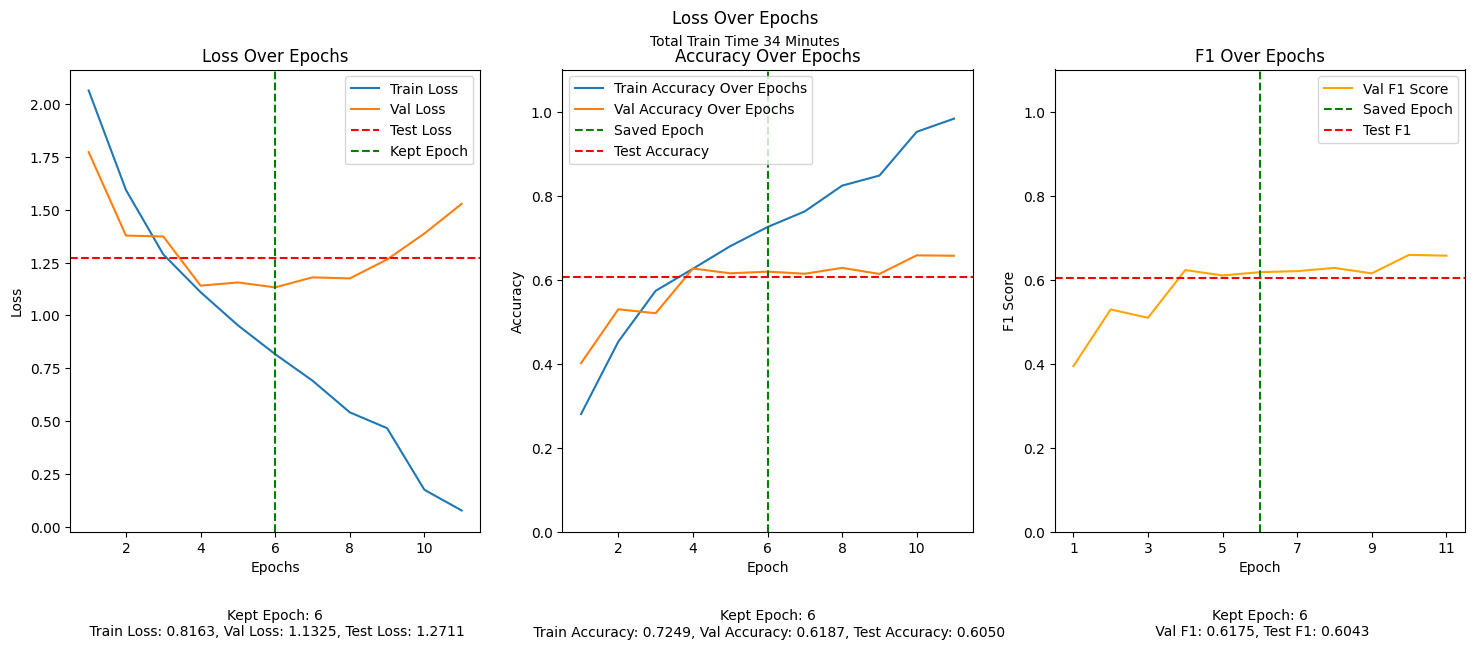

In [6]:
import torchvision as tv
def run_job():
    seed()
    train_loader, val_loader, test_loader = create_loaders(rank, batch_size=64)
    #model hyperparas 
    #num classes for mlp head 
    num_classes = 10

    #training hyperparas 
    #num epochs to train
    num_epochs = 1000
    #patience
    patience = 5
    #max lr 
    lr = 1e-4
    #saving the model, config, logging, and figure
    saving_path = rf'/kaggle/working/base_model'

    model = tv.models.vit_b_16(weights=None).to(rank)
    in_features = model.heads.head.in_features
    model.heads.head = torch.nn.Linear(in_features, num_classes).to(rank)
   
    #loss function
    loss_func = nn.CrossEntropyLoss()

    #optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    #lr scheduler 
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
    #init early stopper 
    early_stopper = EarlyStoppingLoss(patience)

    total_params = sum(para.numel() for para in model.parameters())
    print("Number of parameters: ", total_params)
    print()
    # print("The number of parameters each part of the transfromer model")
    # for name, param in model.named_parameters():
    #     print(f"Layer: {name}, Parameters: {param.numel()}")

    config = {'num_classes': num_classes, 'num_epochs': num_epochs, 'patience': patience, 'lr': lr, 'total_parameters': total_params}
    
    #model training and testing
    model, history, final_stats_dict, logging_str = train(model, train_loader, val_loader, 
                                                          loss_func, optimizer, early_stopper, 
                                                          scheduler, num_epochs)
    #run test partition 
    test_dict = test(model, test_loader, loss_func)

    #plot figure
    fig = plot(history, final_stats_dict, test_dict)
    fig.suptitle(f'Loss Over Epochs')

    save_model(saving_path, fig, config, model, logging_str)
    
run_job()